In this notebook, we consider a ZDT1 problem with Gaussian noise, and benckmark two "denoising" methods:
* a naive average method,
* the KNN-Avg algorithm.

In [1]:
import nmoo

The first step is to construct our problem pipelines. We start with a `ZDT1` instance, that we wrap in a `ProblemWrapper`. In nmoo, `ProblemWrapper` is the base class to modify problems, in our case adding and removing noise. Additionally, `ProblemWrapper` and classes deriving from it maintain a history of every call made to their `_evaluate` method (see the [pymoo documentation](https://pymoo.org/getting_started.html#By-Class)).

Next, we add a Gaussian noise of type `N(0, 0.25)` and the averaging algorithm.

In [2]:
from pymoo.problems.multi import ZDT1
import numpy as np

zdt1 = ZDT1()
wrapped_zdt1 = nmoo.WrappedProblem(zdt1)
mean = np.array([0, 0])
covariance = np.array([[1., -.5], [-.5, 1]])
noisy_zdt1 = nmoo.noises.GaussianNoise(
    wrapped_zdt1, 
    {"F": (mean, covariance)},
)
avg_zdt1 = nmoo.denoisers.ResampleAverage(noisy_zdt1, n_evaluations=10)

We construct a similar pipeline for the KNN-Avg algorithm. Note that parts of
an already existing pipeline can be reused.

In [3]:

knnavg_zdt1 = nmoo.denoisers.KNNAvg(
    noisy_zdt1,
    distance_weight_type="squared",
    max_distance=1.0,
    n_neighbors=100,
)

Now, we setup an algorithm that will try and solve our `avg_zdt1` and `knnavg_zdt1` problems.

In [4]:
from pymoo.algorithms.moo.nsga2 import NSGA2

nsga2 = NSGA2()

Finally, we setup our benchmark. It will run NSGA2 against `avg_zdt1` and
`knnavg_zdt1` tree times each. Additionally, we specify a Pareto front
population to measure the performance. It no Pareto front is specified (or
known), performance indicators will use one automatically calculated based on
the results of the benchmark.

Since the `avg` problem evaluates the underlying noisy `ZDT1` problem 10 times,
we apply a penalty of 10, meaning that every call to `avg.eval` will count as
10 calls.

In [5]:
from pymoo.factory import get_termination

pareto_front = zdt1.pareto_front(100)

benchmark = nmoo.benchmark.Benchmark(
    output_dir_path="./out",
    problems={
        "knnavg": {
            "problem": knnavg_zdt1,
            "pareto_front": pareto_front,
        },
        "avg": {
            "problem": avg_zdt1,
            "pareto_front": pareto_front,
            "evaluator": nmoo.evaluators.EvaluationPenaltyEvaluator("times", 10),
        },
    },
    algorithms={
        "nsga2": {
            "algorithm": nsga2,
        },
        "nsga2_100": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 100),
        },
    },
    n_runs=3,
)

In [6]:
! rm out/*

In [7]:
benchmark.run(verbose=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   47.3s remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   47.3s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  1.5min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  1.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  2.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.2min remaining:   43.4s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  4.6min remaining:   55.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed

Results of the benchmark are automatically saved:

In [8]:
! ls ./out

avg.nsga2.1.1-resample_avg.npz
avg.nsga2.1.2-gaussian_noise.npz
avg.nsga2.1.3-wrapped_problem.npz
avg.nsga2.1.csv
avg.nsga2.1.pi-igd.csv
avg.nsga2.1.pp.npz
avg.nsga2.2.1-resample_avg.npz
avg.nsga2.2.2-gaussian_noise.npz
avg.nsga2.2.3-wrapped_problem.npz
avg.nsga2.2.csv
avg.nsga2.2.pi-igd.csv
avg.nsga2.2.pp.npz
avg.nsga2.3.1-resample_avg.npz
avg.nsga2.3.2-gaussian_noise.npz
avg.nsga2.3.3-wrapped_problem.npz
avg.nsga2.3.csv
avg.nsga2.3.pi-igd.csv
avg.nsga2.3.pp.npz
avg.nsga2.gpp.npz
avg.nsga2_100.1.1-resample_avg.npz
avg.nsga2_100.1.2-gaussian_noise.npz
avg.nsga2_100.1.3-wrapped_problem.npz
avg.nsga2_100.1.csv
avg.nsga2_100.1.pi-igd.csv
avg.nsga2_100.1.pp.npz
avg.nsga2_100.2.1-resample_avg.npz
avg.nsga2_100.2.2-gaussian_noise.npz
avg.nsga2_100.2.3-wrapped_problem.npz
avg.nsga2_100.2.csv
avg.nsga2_100.2.pi-igd.csv
avg.nsga2_100.2.pp.npz
avg.nsga2_100.3.1-resample_avg.npz
avg.nsga2_100.3.2-gaussian_noise.npz
avg.nsga2_100.3.3-wrapped_problem.npz
avg.nsga2_100.3.csv
avg.nsga2_100.3.pi-igd.c

The benchmark results are saved in `benchmark.csv`. They can also be accessed by `benchmark._results`. The rest are problem call histories, named after the following scheme:
```
<problem_name>.<algorithm_name>.<n_run>.<level>-<layer_name>.npz
```
For example, `knnavg.nsga2_100.3.2-gaussian_noise.npz` is the `GaussianNoise`
history (level 2) of the 3rd run of `NSGA2` (100 generations) on the `knnavg`
pipeline. The Pareto populations of each run are stored in the 
```
<problem_name>.<algorithm_name>.<n_run>.pp.npz
```
files, and the global Pareto population for a given problem-algorithm pair is
stored in 
```
<problem_name>.<algorithm_name>.gpp.npz
```
Statistics about each run are stored in the 
```
<problem_name>.<algorithm_name>.<n_run>.csv
```
files. Performance indicators are computed and stored in the
```
<problem_name>.<algorithm_name>.<n_run>.pi-<pi_name>.csv
``` 
files.


Let's now visualize the results. The final result of all runs can be found using the `Benchmark.final_results` method:

In [9]:
benchmark.final_results()

,algorithm,problem,n_run,n_gen,timedelta,perf_igd
0,nsga2,avg,1,100,996277,0.356290
1,nsga2,avg,2,100,45851,0.258755
2,nsga2,avg,3,100,967801,0.192928
3,nsga2,knnavg,1,295,672722,0.260290
4,nsga2,knnavg,2,235,774537,0.378925
5,nsga2,knnavg,3,295,951456,0.185597
6,nsga2_100,avg,1,100,441058,0.533306
7,nsga2_100,avg,2,100,449574,0.171039
8,nsga2_100,avg,3,100,728068,0.167461
9,nsga2_100,knnavg,1,100,760249,0.292001


The following boxplot indicates that, with the same number of calls to `ZDT1`, KNN-Avg offers a better GD+ performance. However, on the number of generation is fixed or unconstrained, then the averaging method is better.

<AxesSubplot:xlabel='problem', ylabel='perf_igd'>

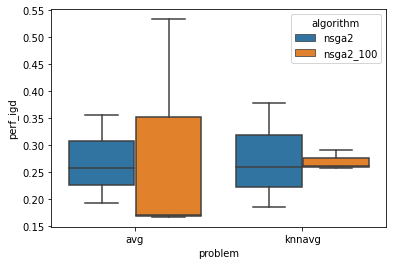

In [10]:
import seaborn as sns

sns.boxplot(
    x="problem", 
    y="perf_igd", 
    hue="algorithm",
    data=benchmark.final_results(),
)

The following boxplot depicts the runtimes.

<AxesSubplot:xlabel='problem', ylabel='timedelta'>

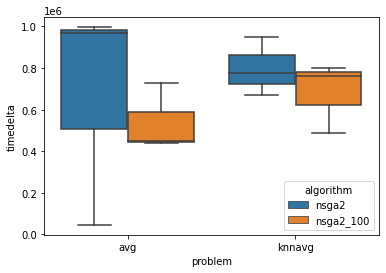

In [11]:
sns.boxplot(
    x="problem", 
    y="timedelta", 
    hue="algorithm",
    data=benchmark.final_results(),
)

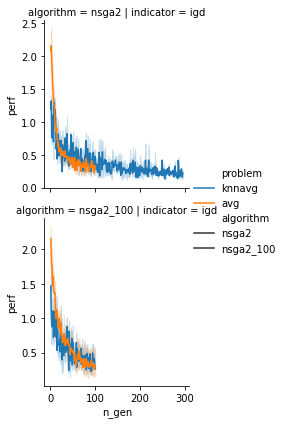

In [12]:
from nmoo.plotting import plot_performance_indicators
plot_performance_indicators(benchmark, row="algorithm")